# **Import libraries**

In [5]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Flatten, Dropout, Dense
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, AveragePooling2D
from keras import regularizers
from keras.layers import GlobalAveragePooling2D, UpSampling2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.applications.inception_v3 import preprocess_input
from keras import optimizers
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
import os
from keras.models import load_model
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
from keras import callbacks

In [ ]:
print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# **Load data** 

In [6]:
drive.mount('/content/drive', force_remount=True)

datadir = '/content/drive/MyDrive/Data'
!cp -r "{datadir}" .
!unzip -q ./Data/\* -d ./imgs

Mounted at /content/drive

8 archives were successfully processed.
1 "zipfile" was a directory.


In [7]:
!pip install split-folders
import splitfolders

In [8]:
splitfolders.ratio("imgs/", output="output", seed=1337, ratio=(.7, .3), group_prefix=None)

Copying files: 8727 files [00:01, 7356.17 files/s]


# **Pre-processing**

 Functions for VGG16

In [6]:
'''def crop(img):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = 224
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)'''

"def crop(img):\n    # Note: image_data_format is 'channel_last'\n    assert img.shape[2] == 3\n    height, width = img.shape[0], img.shape[1]\n    dy, dx = 224\n    x = np.random.randint(0, width - dx + 1)\n    y = np.random.randint(0, height - dy + 1)\n    return img[y:(y+dy), x:(x+dx), :]\n\ndef crop_generator(batches, crop_length):\n    while True:\n        batch_x, batch_y = next(batches)\n        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))\n        for i in range(batch_x.shape[0]):\n            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))\n        yield (batch_crops, batch_y)\n\ndef bgr(img):\n    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)"

In [7]:
#alternative data augmentation level
'''train_datagen = ImageDataGenerator(
                               vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directory="output/train",
    target_size=(139, 139),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)'''

'train_datagen = ImageDataGenerator(\n                               vertical_flip=True,\n                               horizontal_flip=True,\n                               height_shift_range=0.1,\n                               width_shift_range=0.1,\n                               preprocessing_function=preprocess_input)\n\ntrain_generator = train_datagen.flow_from_directory(\n    directory="output/train",\n    target_size=(139, 139),\n    color_mode="rgb",\n    batch_size=batch_size,\n    class_mode="categorical",\n    shuffle=True\n)'

In [9]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False
)

train_generator = train_datagen.flow_from_directory(
    directory="output/train",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255
    )

test_generator = test_datagen.flow_from_directory(
    directory="output/val",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 6105 images belonging to 8 classes.
Found 2622 images belonging to 8 classes.
Image input (256, 256, 3)
Classes: ['Crackers', 'Oatmeal_box', 'Papayas', 'Upholstery_Cleaners', 'basket_container', 'dinnerware', 'snack_bowl', 'soft_drink_bottle']
Loaded 6105 training samples from 8 classes.
Loaded 2622 test samples from 8 classes.


Upholstery_Cleaners


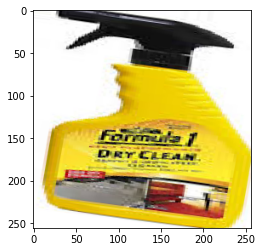

basket_container


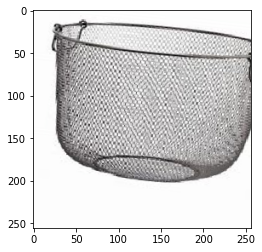

Papayas


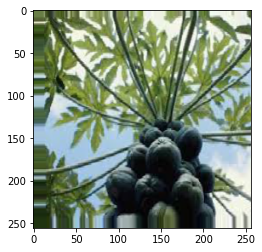

snack_bowl


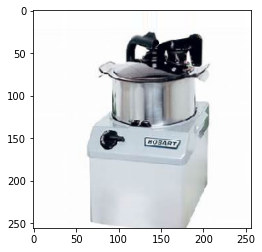

soft_drink_bottle


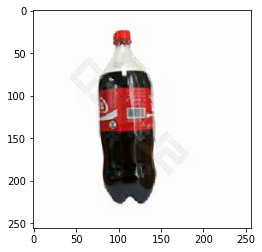

In [9]:
n = 5
x,y = train_generator.next()

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()
    print(classnames[label])
    plt.imshow(image)
    plt.show()

## **LeNet**

In [24]:
def LeNet(input_shape, num_classes):
    
    print('\nLeNet model')
    model = Sequential()
    
    print('\tC1: Convolutional 6 kernels 5x5')
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'))
    print('\tS2: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC3: Convolutional 16 kernels 5x5')
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    print('\tS4: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC5: Convolutional 120 kernels 5x5')
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(Flatten())
    print('\tF6: Fully connected, 84 units')
    model.add(Dense(84, activation='relu'))
    print('\tF7: Fully connected, 10 units')
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = 'adam'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [25]:
model = LeNet(input_shape,num_classes)
model.summary()


LeNet model
	C1: Convolutional 6 kernels 5x5
	S2: Average Pooling 2x2 stride 2x2
	C3: Convolutional 16 kernels 5x5
	S4: Average Pooling 2x2 stride 2x2
	C5: Convolutional 120 kernels 5x5
	F6: Fully connected, 84 units
	F7: Fully connected, 10 units
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 300, 300, 6)       456       
_________________________________________________________________
average_pooling2d_20 (Averag (None, 150, 150, 6)       0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 146, 146, 16)      2416      
_________________________________________________________________
average_pooling2d_21 (Averag (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 69, 69, 120)       48120     
___

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100

stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
try:
    history = model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory="output/val",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

In [ ]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **VGG16**

In [ ]:
def load_vgg16_features(input_shape, init_weights=None):

    input0 = Input(shape=input_shape)

    vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16_features")

    optimizer = 'adam'
    #optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

vgg16feat_model = load_vgg16_features(input_shape)
vgg16feat_model.summary()

In [ ]:
def transferNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    input_t = feature_extractor.get_layer(index=0).input

    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    output_extractor = feature_extractor.get_layer(name = output_layer_name).output

    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    dense1 = Dropout(0.4)(flatten_norm)
    dense1 = Dense(200, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)

    dense2 = Dropout(0.4)(dense1)
    dense2 = Dense(100, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    
    model = keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = 'adam'
    #optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

transfer_model = transferNet(input_shape, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

In [ ]:
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

epochs = 10

try:
    transfer_history = transfer_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory="output/val",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = transfer_model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes

In [ ]:
#accuracy
plt.plot(transfer_history.history['accuracy'])
plt.plot(transfer_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(transfer_history.history['loss'])
plt.plot(transfer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **GoogleNet**

In [14]:
def load_googlenet_features(input_shape, init_weights=None):

    input0 = Input(shape=input_shape)

    googlenet_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = keras.models.Model(inputs=input0, outputs=googlenet_model.output, name="googlenet_features")

    optimizer = 'adam'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

googlenetfeat_model = load_googlenet_features(input_shape)
googlenetfeat_model.summary()

Model: "googlenet_features"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_________________________________________________________________________________

In [15]:
def transferNet3(input_shape, num_classes, output_layer_name, trainable_layers):
    
    feature_extractor = load_googlenet_features(input_shape, init_weights='imagenet')

    input_t = feature_extractor.get_layer(index=0).input

    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    dense1 = Dropout(0.4)(flatten_norm)
    dense1 = Dense(200, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)

    dense2 = Dropout(0.4)(dense1)
    dense2 = Dense(100, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    #dense1 = Dropout(0.5)(flatten_norm)
    #dense3 = Dense(num_classes, activation='softmax')(dense1)
    
    model = keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet3")
    
    optimizer = 'adam' 
    #optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    #optimizer = SGD(lr=1e-4, momentum=0.9)

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

name_output_extractor = "mixed10"
trainable_layers = ["conv2d_192", "batch_normalization_216", "batch_normalization_224"]
#trainable_layers = []

transfer_model3 = transferNet3(input_shape, num_classes, name_output_extractor, trainable_layers)
transfer_model3.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "transferNet3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_97[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
______________________

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 15

stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

try:
    googlenet_history = transfer_model3.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

In [ ]:
 val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory="output/val",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = transfer_model3.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

In [ ]:
#accuracy
plt.plot(googlenet_history.history['accuracy'])
plt.plot(googlenet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(googlenet_history.history['loss'])
plt.plot(googlenet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory="output/val",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = transfer_model3.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes 

cm = confusion_matrix(Ytest, Ypred)

conf = []
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

# **Save model**

In [ ]:
os.makedirs(datadir+"/imgs/models/")

In [ ]:
models_dir = datadir + '/imgs/' + 'models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    transfer_model3.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

savemodel(transfer_model3,'GoogleNet_v1')

# **Load model**

In [ ]:
models_dir = datadir + '/imgs/models/'

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

loaded_model = loadmodel('GoogleNet_v1')